In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2  # Contoh untuk Transfer Learning
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Kita akan butuh OpenCV untuk memproses gambar tulisan tangan
from google.colab import files # Untuk upload file tulisan tangan
import os
import glob

In [2]:
# 1. Muat dan Proses Data MNIST
# Muat dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Simpan label asli untuk visualisasi nanti
y_train_labels = y_train
y_test_labels = y_test

# --- Pra-Pemrosesan ---
# 1. Normalisasi Piksel: Ubah dari 0-255 menjadi 0.0-1.0
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# 2. Reshaping: Tambahkan dimensi channel (28, 28) -> (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# 3. Pembagian Data Latih/Uji sudah dilakukan oleh Keras

# 4. Konversi label (y) menjadi one-hot encoding
#    Contoh: 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("--- Bentuk Data ---")
print("Bentuk x_train (gambar latih):", x_train.shape)
print("Bentuk y_train (label latih):", y_train.shape)
print("Bentuk x_test (gambar uji):", x_test.shape)
print("Bentuk y_test (label uji):", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Bentuk Data ---
Bentuk x_train (gambar latih): (60000, 28, 28, 1)
Bentuk y_train (label latih): (60000, 10)
Bentuk x_test (gambar uji): (10000, 28, 28, 1)
Bentuk y_test (label uji): (10000, 10)


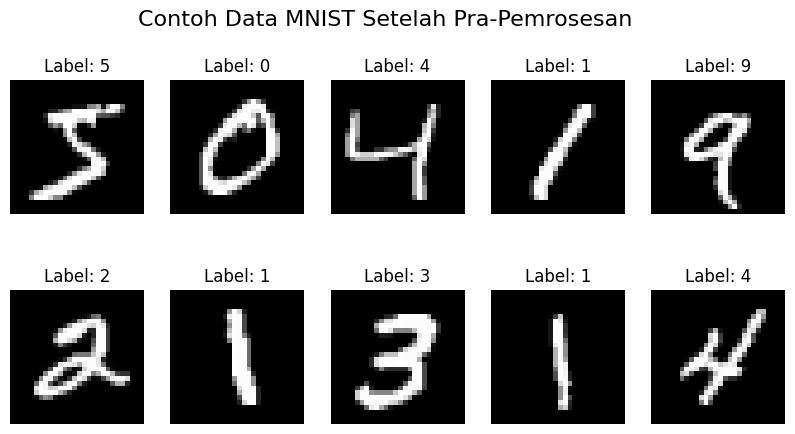

In [3]:
# Visualisasi Data MNIST
# Sesuai instruksi[cite: 14], visualisasikan beberapa contoh citra.
plt.figure(figsize=(10, 5))
plt.suptitle("Contoh Data MNIST Setelah Pra-Pemrosesan", fontsize=16)
for i in range(10): # Tampilkan 10 gambar pertama
    plt.subplot(2, 5, i + 1)
    # Squeeze untuk menghapus dimensi channel (1) agar bisa di-plot
    plt.imshow(np.squeeze(x_train[i]), cmap="gray")
    plt.title(f"Label: {y_train_labels[i]}")
    plt.axis("off")
plt.show()

In [4]:
# Arsitektur Model A (CNN dari Nol)
model_A = Sequential([
    # Input layer
    keras.Input(shape=(28, 28, 1)),

    # Blok Konvolusi 1
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Blok Konvolusi 2
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Lapisan Flatten [cite: 19]
    layers.Flatten(),

    # Lapisan Dense [cite: 20]
    layers.Dense(128, activation="relu"),

    # Lapisan Output [cite: 20]
    layers.Dense(10, activation="softmax") # 10 kelas (0-9)
])

# Tampilkan ringkasan arsitektur
model_A.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Kompilasi model
model_A.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [6]:
# Tentukan parameter pelatihan
BATCH_SIZE = 128
EPOCHS = 10

print("Memulai pelatihan Model A...")

# Latih model [cite: 21]
history_A = model_A.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test) # Evaluasi di data tes
)

print("Pelatihan Model A selesai.")

Memulai pelatihan Model A...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.8507 - loss: 0.4845 - val_accuracy: 0.9793 - val_loss: 0.0643
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9798 - loss: 0.0643 - val_accuracy: 0.9826 - val_loss: 0.0523
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9869 - loss: 0.0422 - val_accuracy: 0.9865 - val_loss: 0.0380
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9897 - loss: 0.0325 - val_accuracy: 0.9900 - val_loss: 0.0299
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9921 - loss: 0.0244 - val_accuracy: 0.9893 - val_loss: 0.0339
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.9940 - loss: 0.0190 - val_accuracy: 0.9877 - val_loss: 0.0358
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.9959 - loss: 0.0154 - val_accuracy: 0.9892 - val_loss: 0.0319
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accu

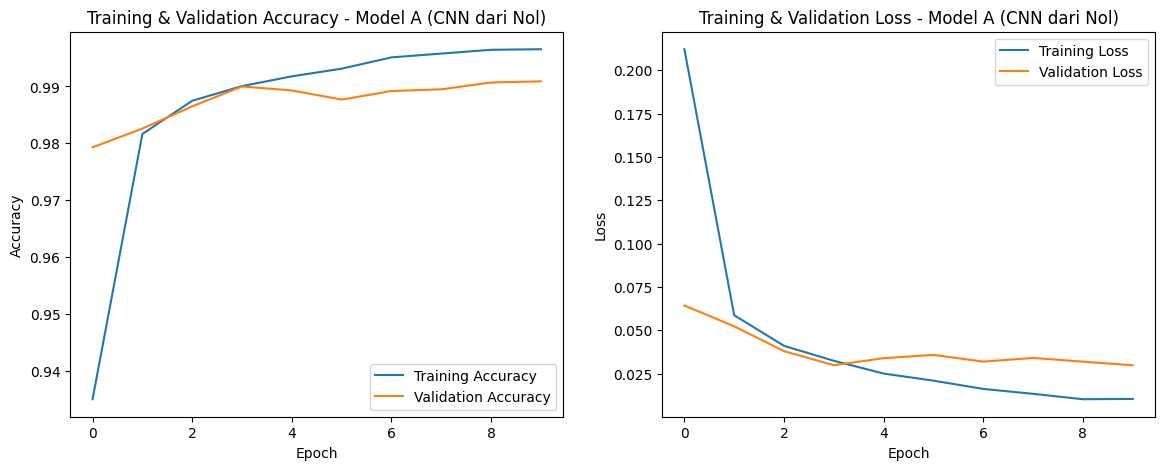

In [7]:
def plot_history(history, title):
    """Fungsi untuk mem-plot akurasi dan loss."""
    plt.figure(figsize=(14, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training & Validation Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training & Validation Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

# Panggil fungsi plot
plot_history(history_A, "Model A (CNN dari Nol)")

In [9]:
# 3. UPLOAD 30 GAMBAR TULISAN TANGAN ANDA
# Buat folder untuk menyimpan gambar
upload_dir = 'gambar_custom'
if not os.path.exists(upload_dir):
    os.makedirs(upload_dir)

print(f"Folder '{upload_dir}' telah disiapkan.")
print("Silakan upload 30 file gambar Anda (10x '0', 10x '2', 10x '3').")
print("Pastikan nama file sesuai format: 'angka_DIGIT_NOMOR.png' (misal: 'angka_0_1.png')")

# Perintah untuk upload
uploaded_files = files.upload()

# Pindahkan file yang di-upload ke folder
for filename, content in uploaded_files.items():
    with open(os.path.join(upload_dir, filename), 'wb') as f:
        f.write(content)

print(f"\nBerhasil meng-upload {len(uploaded_files)} file ke folder '{upload_dir}'.")

Folder 'gambar_custom' telah disiapkan.
Silakan upload 30 file gambar Anda (10x '0', 10x '2', 10x '3').
Pastikan nama file sesuai format: 'angka_DIGIT_NOMOR.png' (misal: 'angka_0_1.png')


Saving 0_1.JPG to 0_1.JPG
Saving 0_2.JPG to 0_2.JPG
Saving 0_3.JPG to 0_3.JPG
Saving 0_4.JPG to 0_4.JPG
Saving 0_5.JPG to 0_5.JPG
Saving 0_6.JPG to 0_6.JPG
Saving 0_7.jpg to 0_7.jpg
Saving 0_8.JPG to 0_8.JPG
Saving 0_10.JPG to 0_10.JPG
Saving 7_3.JPG to 7_3.JPG
Saving 7_4.jpg to 7_4.jpg
Saving 7_6.JPG to 7_6.JPG
Saving 7_9.JPG to 7_9.JPG
Saving 7_10.JPG to 7_10.JPG
Saving 9_1.JPG to 9_1.JPG
Saving 9_2.JPG to 9_2.JPG
Saving 9_3.JPG to 9_3.JPG
Saving 9_4.JPG to 9_4.JPG
Saving 9_5.JPG to 9_5.JPG
Saving 9_6.JPG to 9_6.JPG
Saving 9_7.JPG to 9_7.JPG
Saving 9_8.JPG to 9_8.JPG
Saving 9_9.JPG to 9_9.JPG
Saving 9_10.JPG to 9_10.JPG
Saving 0_9.JPG to 0_9.JPG
Saving 7_1.JPG to 7_1.JPG
Saving 7_2.JPG to 7_2.JPG
Saving 7_5.JPG to 7_5.JPG
Saving 7_7.JPG to 7_7.JPG
Saving 7_8.JPG to 7_8.JPG

Berhasil meng-upload 30 file ke folder 'gambar_custom'.


In [10]:
# Fungsi Pra-Pemrosesan Gambar Custom (untuk Model A)
# Sesuai instruksi [cite: 29]
def preprocess_custom_image_A(image_path):
    # 1. Baca gambar dalam grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: tidak bisa membaca gambar di {image_path}")
        return None

    # 2. Inversi Warna (MNIST: tulisan putih 255, background hitam 0)
    # Gambar Anda (tulisan hitam 0, background putih 255) -> perlu diinversi
    img = 255 - img

    # 3. Resize ke 28x28 piksel
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

    # 4. Normalisasi piksel (0-1)
    img = img.astype("float32") / 255.0

    # 5. Reshape agar sesuai input model (1, 28, 28, 1)
    img_batch = np.reshape(img, (1, 28, 28, 1))

    return img_batch

print("Fungsi 'preprocess_custom_image_A' siap digunakan.")

Fungsi 'preprocess_custom_image_A' siap digunakan.


Visualisasi 3 contoh gambar Anda setelah pra-pemrosesan:


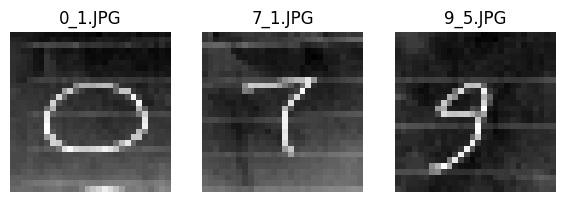

In [12]:
# Visualisasi Gambar Custom Setelah Pra-Pemrosesan
# Sesuai instruksi [cite: 30, 31]

print("Visualisasi 3 contoh gambar Anda setelah pra-pemrosesan:")
plt.figure(figsize=(12, 4))

# Ambil 5 gambar untuk visualisasi (2x '0', 2x '2', 1x '3')
# Pastikan file-file ini ada setelah Anda upload!
files_to_show = [
    'gambar_custom/0_1.JPG',
    'gambar_custom/7_1.JPG',
    'gambar_custom/9_5.JPG',

]

for i, img_path in enumerate(files_to_show):
    if os.path.exists(img_path):
        processed_img = preprocess_custom_image_A(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.squeeze(processed_img), cmap="gray")
        plt.title(f"{img_path.split('/')[-1]}")
        plt.axis("off")
    else:
        print(f"File {img_path} tidak ditemukan untuk visualisasi.")

plt.show()

In [14]:
digits_to_test = [0, 7, 9] # Sesuai NIM Anda 202332023
correct_A = 0
total_A = 0

print("--- Hasil Prediksi Model A (CNN dari Nol) ---")

for digit in digits_to_test:
    for i in range(1, 11): # Untuk 10 gambar per digit
        img_path = f'{upload_dir}/{digit}_{i}.JPG'

        if not os.path.exists(img_path):
            print(f"PERINGATAN: File {img_path} tidak ditemukan, dilewati.")
            continue

        # 1. Proses gambar
        processed_img = preprocess_custom_image_A(img_path)
        total_A += 1

        # 2. Lakukan prediksi
        prediction = model_A.predict(processed_img)
        predicted_label = np.argmax(prediction)

        # 3. Cek kebenaran
        true_label = digit
        is_correct = (predicted_label == true_label)
        if is_correct:
            correct_A += 1

        # 4. Sajikan hasil prediksi [cite: 34]
        print(f"Gambar: {img_path.split('/')[-1]} (Asli: {true_label}) -> Prediksi: {predicted_label} ({'BENAR' if is_correct else 'SALAH'})")

--- Hasil Prediksi Model A (CNN dari Nol) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Gambar: 0_1.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Gambar: 0_2.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Gambar: 0_3.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Gambar: 0_4.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Gambar: 0_5.JPG (Asli: 0) -> Prediksi: 3 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Gambar: 0_6.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
PERINGATAN: File gambar_custom/0_7.JPG tidak ditemukan, dilewati.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Gambar: 0_8.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Gambar: 0_9.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Gambar: 0_10.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Gambar: 7_1.JPG (Asli: 7) -> Prediksi: 1 (SALAH)
1/1 ━━━━━━━━━━━━

In [15]:
# Hitung akurasi final [cite: 33]
if total_A > 0:
    accuracy_A_percent = (correct_A / total_A) * 100
    print("\n--- Ringkasan Akurasi Model A ---")
    print(f"Total Gambar Ditemukan: {total_A}")
    print(f"Total Prediksi Benar: {correct_A}")
    print(f"Akurasi Model A pada Tulisan Tangan Anda: {accuracy_A_percent:.2f}%")
else:
    print("\nTidak ada gambar yang dievaluasi. Pastikan Anda sudah meng-upload gambar.")
    accuracy_A_percent = 0.0


--- Ringkasan Akurasi Model A ---
Total Gambar Ditemukan: 28
Total Prediksi Benar: 8
Akurasi Model A pada Tulisan Tangan Anda: 28.57%


In [16]:
# Ukuran input minimum untuk MobileNetV2
INPUT_SIZE_B = 32

print("Mempersiapkan data MNIST untuk Model B...")
# 1. Konversi data latih ke 3-channel (RGB)
x_train_B = tf.image.grayscale_to_rgb(tf.constant(x_train)).numpy()
# 2. Resize data latih ke 32x32
x_train_B = tf.image.resize(x_train_B, [INPUT_SIZE_B, INPUT_SIZE_B]).numpy()

# Ulangi untuk data tes
x_test_B = tf.image.grayscale_to_rgb(tf.constant(x_test)).numpy()
x_test_B = tf.image.resize(x_test_B, [INPUT_SIZE_B, INPUT_SIZE_B]).numpy()

# Label (y_train, y_test) tetap sama (one-hot encoding)

print("\n--- Bentuk Data Baru (untuk Model B) ---")
print("Bentuk x_train_B:", x_train_B.shape)
print("Bentuk x_test_B:", x_test_B.shape)

Mempersiapkan data MNIST untuk Model B...

--- Bentuk Data Baru (untuk Model B) ---
Bentuk x_train_B: (60000, 32, 32, 3)
Bentuk x_test_B: (10000, 32, 32, 3)


In [17]:
# Ganti baris impor di Sel 0 dengan ini:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [18]:
# 1. Muat base model (MobileNetV2)
base_model = MobileNetV2(
    input_shape=(INPUT_SIZE_B, INPUT_SIZE_B, 3),
    include_top=False, # Tidak menyertakan top layer (klasifikasi ImageNet)
    weights='imagenet' # Gunakan bobot pre-trained
)

# 2. Bekukan (freeze) lapisan dasar [cite: 40]
# Kita tidak ingin melatih ulang bobot MobileNetV2
base_model.trainable = False

# 3. Buat model baru di atas base model
# Kita ambil output dari base_model dan tambahkan layer kita sendiri
x = base_model.output
x = GlobalAveragePooling2D()(x) # Mengubah fitur map menjadi vektor
# Tambahkan lapisan output baru untuk 10 kelas [cite: 38]
output_layer = Dense(10, activation='softmax')(x)

# Gabungkan menjadi model B
model_B = Model(inputs=base_model.input, outputs=output_layer)

# Tampilkan ringkasan arsitektur
model_B.summary()

/tmp/ipython-input-2327222248.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# Kompilasi model B
model_B.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [20]:
# Parameter pelatihan (biasanya butuh epoch lebih sedikit)
BATCH_SIZE_B = 128
EPOCHS_B = 5 # Cukup 5 epoch karena kita hanya melatih top layer

print("Memulai pelatihan Model B (Transfer Learning)...")

Memulai pelatihan Model B (Transfer Learning)...


In [21]:
# Latih Model B [cite: 39]
history_B = model_B.fit(
    x_train_B,
    y_train, # Label y tetap sama
    batch_size=BATCH_SIZE_B,
    epochs=EPOCHS_B,
    validation_data=(x_test_B, y_test)
)

print("Pelatihan Model B selesai.")

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 118ms/step - accuracy: 0.3803 - loss: 2.0228 - val_accuracy: 0.5503 - val_loss: 1.5612
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.5607 - loss: 1.4993 - val_accuracy: 0.5883 - val_loss: 1.3424
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.5968 - loss: 1.3135 - val_accuracy: 0.6145 - val_loss: 1.2323
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.6190 - loss: 1.2178 - val_accuracy: 0.6289 - val_loss: 1.1658
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 119ms/step - accuracy: 0.6316 - loss: 1.1575 - val_accuracy: 0.6377 - val_loss: 1.1215
Pelatihan Model B selesai.


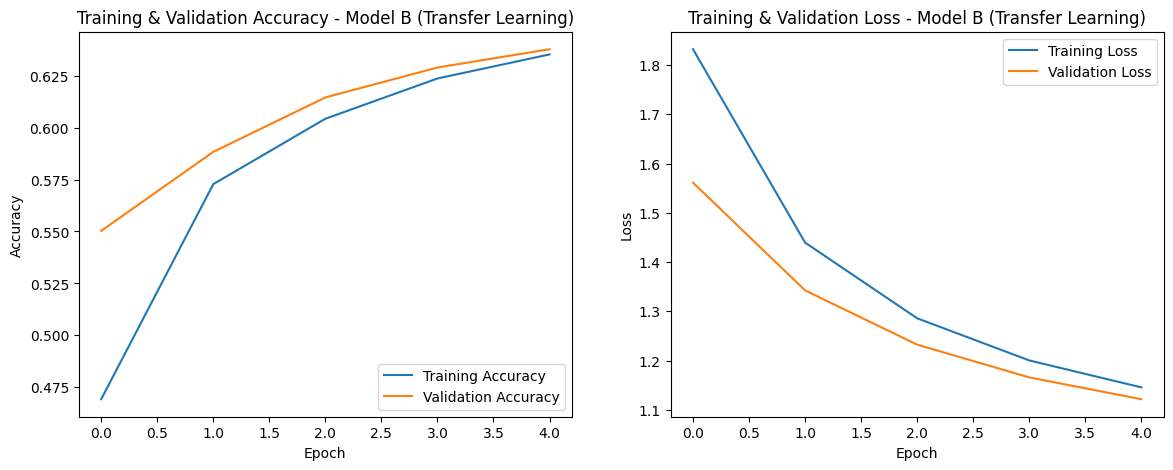

In [22]:
# Kita panggil lagi fungsi plot_history yang sudah kita buat
plot_history(history_B, "Model B (Transfer Learning)")

In [27]:
#Fungsi Pra-Pemrosesan Gambar Custom (untuk Model B)
def preprocess_custom_image_B(image_path):
    # 1. Baca gambar dalam grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # 2. Inversi Warna (Sama seperti Model A)
    img = 255 - img

    # 3. Konversi ke 3-Channel (RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # 4. Resize ke 32x32 (sesuai input Model B)
    img_resized = cv2.resize(img_rgb, (INPUT_SIZE_B, INPUT_SIZE_B), interpolation=cv2.INTER_AREA)

    # 5. Normalisasi piksel (0-1)
    img_norm = img_resized.astype("float32") / 255.0

    # 6. Reshape untuk batch (1, 32, 32, 3)
    img_batch = np.reshape(img_norm, (1, INPUT_SIZE_B, INPUT_SIZE_B, 3))

    return img_batch

print("Fungsi 'preprocess_custom_image_B' siap digunakan.")

Fungsi 'preprocess_custom_image_B' siap digunakan.


In [30]:
#Evaluasi Akurasi Model B pada Gambar Custom
# Sesuai instruksi [cite: 44, 45]

correct_B = 0
total_B = 0 # Gunakan total_A dari evaluasi sebelumnya untuk konsistensi

print("--- Hasil Prediksi Model B (Transfer Learning) ---")

for digit in digits_to_test:
    for i in range(1, 11): # Untuk 10 gambar per digit
        img_path = f'{upload_dir}/{digit}_{i}.JPG'

        if not os.path.exists(img_path):
            # Pesan error sudah ditampilkan di evaluasi Model A
            continue

        # 1. Proses gambar untuk Model B
        processed_img_B = preprocess_custom_image_B(img_path)
        total_B += 1

        # 2. Lakukan prediksi
        prediction = model_B.predict(processed_img_B)
        predicted_label = np.argmax(prediction)

        # 3. Cek kebenaran
        true_label = digit
        is_correct = (predicted_label == true_label)
        if is_correct:
            correct_B += 1

        # 4. Sajikan hasil prediksi [cite: 45]
        print(f"Gambar: {img_path.split('/')[-1]} (Asli: {true_label}) -> Prediksi: {predicted_label} ({'BENAR' if is_correct else 'SALAH'})")

--- Hasil Prediksi Model B (Transfer Learning) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Gambar: 0_1.JPG (Asli: 0) -> Prediksi: 5 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Gambar: 0_2.JPG (Asli: 0) -> Prediksi: 5 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Gambar: 0_3.JPG (Asli: 0) -> Prediksi: 5 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Gambar: 0_4.JPG (Asli: 0) -> Prediksi: 5 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Gambar: 0_5.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Gambar: 0_6.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Gambar: 0_8.JPG (Asli: 0) -> Prediksi: 5 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Gambar: 0_9.JPG (Asli: 0) -> Prediksi: 5 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Gambar: 0_10.JPG (Asli: 0) -> Prediksi: 0 (BENAR)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Gambar: 7_1.JPG (Asli: 7) -> Prediksi: 4 (SALAH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Gambar: 7_2.JPG (Asli: 7) -> Prediksi: 

In [31]:
# Hitung akurasi final [cite: 45]
if total_B > 0:
    accuracy_B_percent = (correct_B / total_B) * 100
    print("\n--- Ringkasan Akurasi Model B ---")
    print(f"Total Gambar Ditemukan: {total_B}")
    print(f"Total Prediksi Benar: {correct_B}")
    print(f"Akurasi Model B pada Tulisan Tangan Anda: {accuracy_B_percent:.2f}%")
else:
    print("\nTidak ada gambar yang dievaluasi.")
    accuracy_B_percent = 0.0


--- Ringkasan Akurasi Model B ---
Total Gambar Ditemukan: 28
Total Prediksi Benar: 6
Akurasi Model B pada Tulisan Tangan Anda: 21.43%


In [32]:
print("--- 📊 HASIL AKHIR PERBANDINGAN MODEL ---")
print(f"Akurasi Model A (CNN dari Nol): {accuracy_A_percent:.2f}%")
print(f"Akurasi Model B (Transfer Learning): {accuracy_B_percent:.2f}%")

--- 📊 HASIL AKHIR PERBANDINGAN MODEL ---
Akurasi Model A (CNN dari Nol): 28.57%
Akurasi Model B (Transfer Learning): 21.43%
